<a href="https://colab.research.google.com/github/zenaiev/hep/blob/main/unfold/unfold_cpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install ROOT

In [1]:
!wget https://root.cern/download/root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
!tar -xzf root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
import os
pwd = os.getcwd()
os.environ['ROOTSYS'] = pwd + '/root'
os.environ['PATH'] += ':' + pwd + '/root/bin'
os.environ['LD_LIBRARY_PATH'] += ':' + pwd + '/root/lib'
import sys
sys.path.append(pwd + '/root/lib')
#import ROOT
#print(ROOT.__version__)

--2024-10-23 16:04:30--  https://root.cern/download/root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz
Resolving root.cern (root.cern)... 188.184.49.144, 2001:1458:d00:55::100:c
Connecting to root.cern (root.cern)|188.184.49.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300006880 (286M) [application/x-gzip]
Saving to: ‘root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz’

root_v6.32.04.Linux 100%[===================>] 286.11M  26.8MB/s    in 11s     

2024-10-23 16:04:42 (24.9 MB/s) - ‘root_v6.32.04.Linux-ubuntu22.04-x86_64-gcc11.4.tar.gz’ saved [300006880/300006880]



Downlod RooUnfold

In [2]:
!rm -rf RooUnfold
!git clone https://gitlab.cern.ch/RooUnfold/RooUnfold.git


Cloning into 'RooUnfold'...
remote: Enumerating objects: 5528, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 5528 (delta 135), reused 161 (delta 101), pack-reused 5312 (from 1)
Receiving objects: 100% (5528/5528), 3.39 MiB | 3.93 MiB/s, done.
Resolving deltas: 100% (4298/4298), done.


Compile RooUnfold

In [3]:
os.chdir(pwd + '/RooUnfold')
!mkdir build
os.chdir(pwd + '/RooUnfold/build')
!cmake ..
!make -j17
os.environ['LD_LIBRARY_PATH'] += ':' + pwd + '/RooUnfold/build'
#os.chdir(pwd)
#import RooUnfold


CMake Deprecation Warning at CMakeLists.txt:9 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Vdt: /content/root/include (found version "0.4")
Setup using plain ROOT
-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
Doxygen need to be installed to generate the doxyg

Write C++ code to file unfold.cpp

In [11]:
%%writefile unfold.cpp
#if !(defined(__CINT__) || defined(__CLING__)) || defined(__ACLIC__)
#include <iostream>
using std::cout;
using std::endl;

#include "TRandom.h"
#include "TH1D.h"
#include "TCanvas.h"

#include "RooUnfoldResponse.h"
#include "RooUnfoldBayes.h"
#include "RooUnfoldSvd.h"
#include "RooUnfoldTUnfold.h"
#include "RooUnfoldIds.h"
#include <iostream>
#include <random>
#include <vector>
#include <TCanvas.h>
#include <TH1F.h>
#include <TLegend.h>
#include <TSystem.h>
#include <TFile.h>
#include <TApplication.h>
#include <TROOT.h>
#include <TCanvas.h>
#include <TGraph.h>
#include <TLine.h>
#include <TMath.h>
#include <TStyle.h>
#endif

using namespace std;

double smear(double momentum) {
    static default_random_engine generator(42); // random seed for reproducibility
    normal_distribution<double> distribution(0.75, 0.25);
    double fluct = distribution(generator);
    return momentum * fluct;
}

void generate(int nevents, double lambda_exp,
              RooUnfoldResponse* response = nullptr,
              TH1F* h_true = nullptr,
              TH1F* h_reco = nullptr) {
    static default_random_engine generator(42); // random seed for reproducibility
    exponential_distribution<double> exp_dist(lambda_exp);

    for (int i = 0; i < nevents; ++i) {
        double momentum_true = exp_dist(generator);
        double momentum_measured = smear(momentum_true);

        if (response) {
            response->Fill(momentum_measured, momentum_true);
        }
        if (h_reco) {
            h_reco->Fill(momentum_measured);
        }
        if (h_true) {
            h_true->Fill(momentum_true);
        }
    }
}

int main() {
//int unfold() {
    // Initialize ROOT application
    //TApplication app("app", nullptr, nullptr);

    // Draw smearing distribution
    TCanvas* fig = new TCanvas("canvas", "Smearing", 800, 600);
    TH1F* h_smear_02 = new TH1F("h_smear_02", "Smear for p = 0.2 GeV", 50, 0, 3.);
    TH1F* h_smear_2 = new TH1F("h_smear_2", "Smear for p = 2 GeV", 50, 0, 3.);

    for (int i = 0; i < 10000; ++i) {
        h_smear_02->Fill(smear(0.2));
        h_smear_2->Fill(smear(2.0));
    }

    h_smear_02->SetLineColor(kBlue);
    h_smear_2->SetLineColor(kRed);
    h_smear_02->Draw();
    h_smear_2->Draw("SAME");

    TLine* line1 = new TLine(0.2, 0, 0.2, h_smear_02->GetMaximum());
    line1->SetLineColor(kBlack);
    line1->Draw();

    TLine* line2 = new TLine(2.0, 0, 2.0, h_smear_2->GetMaximum());
    line2->SetLineColor(kBlack);
    line2->Draw();

    fig->SaveAs("smeared.pdf");
    fig->SaveAs("smeared.png");

    // Generate events
    double lambda_exp = 2.0;
    RooUnfoldResponse response(120, 0., 3., 30, 0., 3.);
    generate(100000, lambda_exp, &response);

    TH1F* h_data = new TH1F("h_data", "Data", 120, 0., 3.);
    TH1F* h_true = new TH1F("h_true", "True", 30, 0., 3.);
    generate(100000, lambda_exp, nullptr, h_true, h_data);

    // Unfolding (unregularised and regularised)
    auto unfold_noreg = new RooUnfoldTUnfold(&response, h_data, 0.);
    auto h_unfold_noreg = unfold_noreg->Hunfold();

    auto unfold_reg = new RooUnfoldTUnfold(&response, h_data);
    //unfold_reg->OptimiseTau();
    auto h_unfold_reg = unfold_reg->Hunfold();

    // Plotting response matrix
    TCanvas* c_2d = new TCanvas("canvas_2d", "Response", 600, 600);
    auto h_response = response.Hresponse();
    h_response->SetStats(0);
    h_response->GetXaxis()->SetTitle("momentum [GeV] (reco)");
    h_response->GetYaxis()->SetTitle("momentum [GeV] (true)");
    h_response->Draw("COLZ");
    c_2d->SaveAs("response.pdf");
    c_2d->SaveAs("response.png");

    // Plot true, reconstructed and unfolded distributions
    TCanvas* c_1d = new TCanvas("canvas_1d", "Unfolding", 300, 600);
    c_1d->Divide(1, 3);

    h_data->SetLineColor(kBlue);
    h_true->SetLineColor(kBlack);
    h_unfold_noreg->SetLineColor(kRed);
    h_unfold_reg->SetLineColor(kMagenta);

    // Rescale data for plotting
    h_data->Scale(h_true->Integral("width") / h_data->Integral("width"));

    auto draw_all = [&]() {
        h_data->Draw("hist");
        h_true->Draw("hist same");
        h_unfold_noreg->Draw("E0 same");
        h_unfold_reg->Draw("E0 same");
    };

    c_1d->cd(1);
    draw_all();

    TLegend* legend = new TLegend(0.5, 0.6, 0.9, 0.9);
    legend->AddEntry(h_true, "True", "l");
    legend->AddEntry(h_data, "Reco", "l");
    legend->AddEntry(h_unfold_noreg, "Reco unfolded (unregularised)", "l");
    legend->AddEntry(h_unfold_reg, "Reco unfolded (regularised)", "l");
    legend->Draw();

    c_1d->cd(2);
    draw_all();
    gPad->SetLogy();

    c_1d->cd(3);
    TH1F* h_unfold_noreg_ratio = static_cast<TH1F*>(h_unfold_noreg->Clone("h_unfold_noreg_ratio"));
    h_unfold_noreg_ratio->Divide(h_true);
    TH1F* h_unfold_reg_ratio = static_cast<TH1F*>(h_unfold_reg->Clone("h_unfold_reg_ratio"));
    h_unfold_reg_ratio->Divide(h_true);

    h_unfold_noreg_ratio->GetXaxis()->SetTitle("momentum [GeV]");
    h_unfold_noreg_ratio->GetYaxis()->SetTitle("Events");
    h_unfold_noreg_ratio->SetStats(0);
    h_unfold_noreg_ratio->Draw("E0");
    h_unfold_reg_ratio->Draw("E0 same");

    c_1d->SaveAs("unfolding.pdf");
    c_1d->SaveAs("unfolding.png");

    //app.Run(); // Run the application

    delete h_smear_02;
    delete h_smear_2;
    delete h_data;
    delete h_true;
    delete h_unfold_noreg;
    delete h_unfold_reg;
    delete c_2d;
    delete c_1d;

    return 0;
}


Overwriting unfold.cpp


Check what is in unfold.cpp

In [12]:
!ls
!cat unfold.cpp

CMakeCache.txt		RooUnfold	       RooUnfoldInvert.h       smeared.png
CMakeFiles		RooUnfoldBayes.h       RooUnfold_LinkDef.h     TUnfoldBinning.h
cmake_install.cmake	RooUnfoldBinByBin.h    RooUnfoldParms.h        TUnfoldBinningXML.h
G__RooUnfold.cxx	RooUnfoldConfig.cmake  RooUnfoldPoisson.h      TUnfoldDensity.h
libRooUnfold_rdict.pcm	RooUnfoldErrors.h      RooUnfoldResponse.h     TUnfold.h
libRooUnfold.rootmap	RooUnfoldFitHelpers.h  RooUnfoldSvd.h	       TUnfoldIterativeEM.h
libRooUnfold.so		RooUnfoldGP.h	       RooUnfoldTargets.cmake  TUnfoldSys.h
Makefile		RooUnfold.h	       RooUnfoldTH1Helpers.h   unfold
response.pdf		RooUnfoldHelpers.h     RooUnfoldTUnfold.h      unfold.cpp
response.png		RooUnfoldHelpers.tpp   setup.sh		       unfolding.pdf
RooFitUnfold.h		RooUnfoldIds.h	       smeared.pdf	       unfolding.png
#if !(defined(__CINT__) || defined(__CLING__)) || defined(__ACLIC__)
#include <iostream>
using std::cout;
using std::endl;

#include "TRandom.h"
#include "TH1D.h"
#include "T

Compile and run C++ code

In [13]:
#!root -l -q unfold.cpp
!g++ unfold.cpp -o unfold `root-config --libs --cflags` -I /content/RooUnfold/build/ -I /content/RooUnfold/src -lRooUnfold -L /content/RooUnfold/build/
import os
os.environ['LD_LIBRARY_PATH'] += ':' + pwd
print(os.environ['LD_LIBRARY_PATH'])
print(pwd)
!./unfold


/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/root/lib:/content/RooUnfold/build:/content:/content
/content
Info in <TCanvas::Print>: pdf file smeared.pdf has been created
Info in <TCanvas::Print>: png file smeared.png has been created
Info in <TUnfoldV17::SetConstraint>: fConstraint=1
Info in <TUnfoldV17::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfoldV17::TUnfold>: 120 input bins and 30 output bins
Info in <TUnfoldV17::TUnfold>: 2 regularisation conditions have been skipped
Info in <TUnfoldV17::SetConstraint>: fConstraint=1
Info in <TUnfoldV17::SetConstraint>: fConstraint=1
Info in <TUnfoldV17::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfoldV17::TUnfold>: 120 input bins and 30 output bins
Info in <TUnfoldV17::TUnfold>: 2 regularisation conditions have been skipped
Info in <TUnfoldV17::SetConstraint>: fConstraint=1
Info in <TUnfoldV17::ScanLcurve>: logtau=-Infinity X=2.235279 Y=8.331440
Info in <TUnfol

View plots

CMakeCache.txt		RooUnfold	       RooUnfoldInvert.h       smeared.png
CMakeFiles		RooUnfoldBayes.h       RooUnfold_LinkDef.h     TUnfoldBinning.h
cmake_install.cmake	RooUnfoldBinByBin.h    RooUnfoldParms.h        TUnfoldBinningXML.h
G__RooUnfold.cxx	RooUnfoldConfig.cmake  RooUnfoldPoisson.h      TUnfoldDensity.h
libRooUnfold_rdict.pcm	RooUnfoldErrors.h      RooUnfoldResponse.h     TUnfold.h
libRooUnfold.rootmap	RooUnfoldFitHelpers.h  RooUnfoldSvd.h	       TUnfoldIterativeEM.h
libRooUnfold.so		RooUnfoldGP.h	       RooUnfoldTargets.cmake  TUnfoldSys.h
Makefile		RooUnfold.h	       RooUnfoldTH1Helpers.h   unfold
response.pdf		RooUnfoldHelpers.h     RooUnfoldTUnfold.h      unfold.cpp
response.png		RooUnfoldHelpers.tpp   setup.sh		       unfolding.pdf
RooFitUnfold.h		RooUnfoldIds.h	       smeared.pdf	       unfolding.png


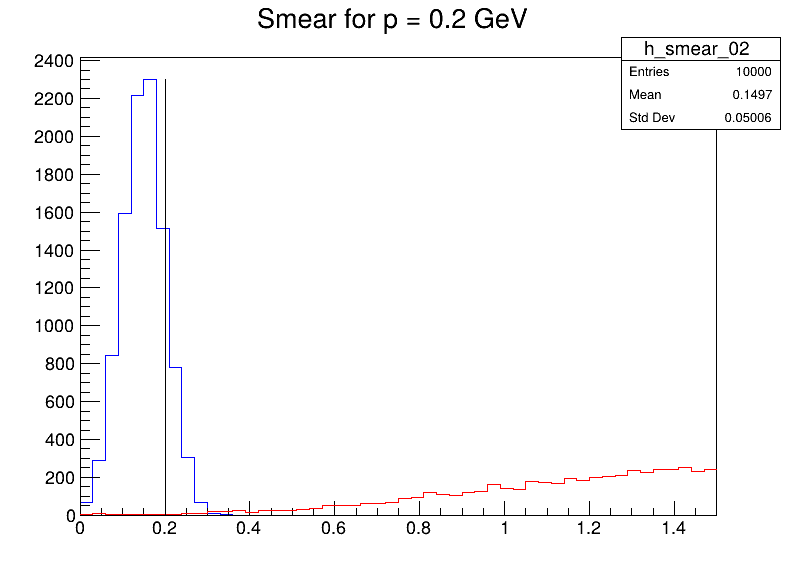

In [8]:
!ls
from IPython.display import Image
Image('smeared.png')

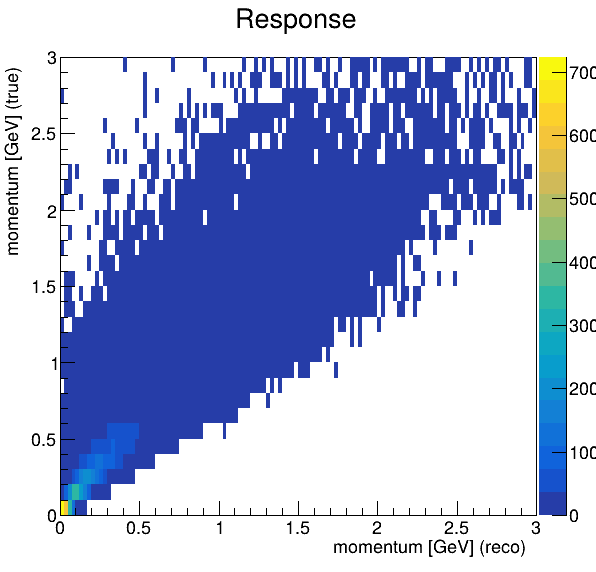

In [9]:
Image('response.png')

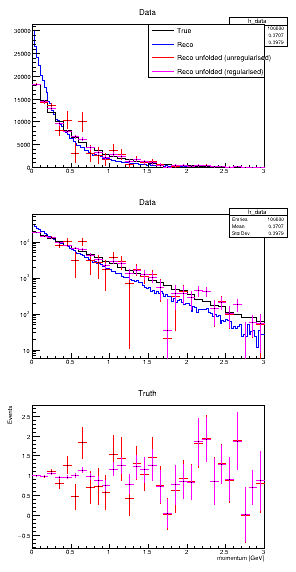

In [10]:
Image('unfolding.png')